# JWST SI Keyword Search for Exoplanet Spectra
## Introduction

This tutorial will illustrate how to use the MAST API to search for JWST science data by values of [FITS](https://fits.gsfc.nasa.gov/fits_standard.html) header keywords, and then retrieve all products for the corresponding observations. 
Searching by SI Keyword values and accessing all data products is not supported in the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), nor with the [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) `Observations` class by itself. Rather, we will be using `astroquery.mast`'s `Mast` class to make direct calls to the MAST API. 

Specifically, this tutorial will show you how to:
* Use the `Mast` class of [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) to search for JWST science files by values of [FITS](https://fits.gsfc.nasa.gov/fits_standard.html) header keywords
* Construct a unique set of Observation IDs to perform a search with the astroquery.mast `Observation` class
* Fetch the unique data products associated with the Observations
* Filter the results for science products
* Download a bash script to retrieve the filtered products

<div class="alert alert-block alert-info">

<span style="color:black">
Here are key distinctions between the two search methods with <a href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">astroquery.mast</a>:
    <ul>
        <li> <b>Advanced Search for Observations:</b> Uses the <code>Observations</code> class to search for data products that match certain metadata values. The <a href="https://mast.stsci.edu/api/v0/_productsfields.html">available metadata</a> upon which to conduct such a search is limited to coordinates, timestamps, and a modest set of instrument configuration information. Returns MAST <code>Observations</code> objects, which are collections of all levels of products (all formats) and all ancillary data products. </li>
        <li> <b>SI Keyword Search:</b> Uses the <code>Mast</code> class to search for FITS products that match values of user-specified keywords, where the set of possible keywords is very large. Returns only FITS products, and only finds highest level of calibrated products (generally, L-2b and L-3). </li>
    </ul>
</span>
</div>

Connecting files that match keyword values to observations is not difficult, but it is a little convoluted. First, you'll use the API to perform a Science Instrument (SI) Keyword Search to find matching product files. The names of these files contain the MAST Observation ID as a sub-string. Then we can use the IDs to perform an advanced `Observation` search for matching Observations.

Here are the steps in the process:

<a href="#Imports">Imports</a>
<br>

<a href="#Example">Part I: Keyword Search for Exoplanet Spectra</a>
<ul>
    <li><a href="#Criteria">Specify Search Criteria</a></li>
    <li><a href="#Timestamp">Add a Date Range</a></li>
    <li><a href="#KW Search">Execute the Keyword Search</a></li><br>
</ul>
<a href="#Obs IDs">Part II: Convert to Observation Search</a>
<ul>
    <li><a href="#Construct">Contstruct the Observation Search</a></li>
    <li><a href="#Obs Query">Execute the Observation Search</a></li>
    <br>
</ul>
<a href="#Data Products">Part III: Download Data Products</a>
<ul>
    <li><a href="#Query DP">Query for Data Products</a></li>
    <li><a href="#Product Filters">Filter the Data Products</a></li>
    <li><a href="#Download Products">Download the Data Products</a></li>
        <ul>
            <li><a href="#Login">Optional: MAST Login</a></li>
            <li><a href="#Retrieve Files">Retrieve Files</a></li>
        </ul>
<br>
</ul>
<a href="#Resources">Additional Resources</a>



## Imports
<a id="Imports"></a>

The following packages are needed for this tutorial: 
* [astropy.io](https://docs.astropy.org/en/stable/io/fits/index.html?highlight=astropy.io) allows us to open the `.fits` files that we download
* [astropy.table](https://docs.astropy.org/en/stable/table/index.html?highlight=astropy.table) holds the results of our product query and finds the unique files
* [astropy.time](https://docs.astropy.org/en/stable/time/index.html) creates `Time` objects and converts between time representations
* [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) constructs the queries, retrieves tables of results, and retrieves data products
* [matplotlib.pyplot](https://matplotlib.org/stable/tutorials/index.html) is a common plotting tool that we'll use to look at our results

In [ ]:
from astropy.io import fits
from astropy.table import unique, vstack
from astropy.time import Time
from astroquery.mast import Mast,Observations

import matplotlib.pyplot as plt

<a id="Example"></a>
# I : Keyword Search for Exoplanet Spectra

This example shows how to search for [NIRISS spectral time-series observations (TSO)](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-single-object-slitless-spectroscopy) taken of transiting exo-planets. The data are from Commissioning or Early Release Science programs, and are therefore public. 

## Specify Search Criteria
<a id="Criteria"></a>

The criteria for SI Keyword searches consists of FITS header keyword name/value pairs. **Learn more about SI keywords from the [JWST Keyword Dictionary](https://mast.stsci.edu/portal/Mashup/Clients/jwkeywords/index.html), and about the supported set of [keyword values](https://mast.stsci.edu/api/v0/_jwst_inst_keywd.html) that can be queried.** With this kind of query it is necessary to construct a specific structure to hold the query parameters. 

The following helper routines translate a simple dictionary (one that is easy to customize in Python) to the required [JSON](https://www.w3schools.com/js/js_json_intro.asp)-style syntax, while the second creates a Min:Max pair of parameters for date-time stamps which, as with all parameters that vary continuously, must be expressed as a range of values in a dictionary. 

In [ ]:
def set_params(parameters):
    return [{"paramName" : p, "values" : v} for p, v in parameters.items()]

def set_mjd_range(min, max):
    '''Set time range in MJD given limits expressed as ISO-8601 dates'''
    return {
        "min": Time(min, format='isot').mjd, 
        "max": Time(max, format='isot').mjd
        }

## Add a Date Range
<a id="Timestamp"></a>

A date range is specified here (though is not strictly needed) to illustrate how to express these common parameters. For historical reasons, the `astroquery.mast` parameter names for timestamps come in pairs: one with a similar name to the corresponding FITS keyword (e.g. `data_obs`), and another with the string <code>_mjd</code> appended (e.g. `date_obs_mjd`). The values are equivalent, but are expressed in ISO-8601 and MJD representations, respectively. 

Change or add keywords and values to the <code>keywords</code> dictionary below to customize your criteria. Note that multiple, discreet-valued parameters are given in a list. As a reminder, if you are unsure of your keyword and keyword value options, see the [Field Descriptions of JWST Instrument Keywords](https://mast.stsci.edu/api/v0/_jwst_inst_keywd.html) and [JWST Keyword Dictionary](https://mast.stsci.edu/portal/Mashup/Clients/jwkeywords/index.html).

In [ ]:
# Looking for NIRISS SOSS commissioning and ERS data taken between June 1st and August 4th
keywords = {'category': ['COM','ERS'],
            'exp_type': ['NIS_SOSS'],
            'tsovisit': ['T'],
            'date_obs_mjd': [set_mjd_range('2022-06-01','2022-08-04')]
           }

# Restructuring the keywords dictionary to the MAST syntax
params = {'columns': '*',
          'filters': set_params(keywords)
         }

The following cell displays the constructed parameter object to illustrate the syntax for the query, which is described formally [here](https://mast.stsci.edu/api/v0/_services.html#MastScienceInstrumentKeywordsNircam). 

In [ ]:
params

<a id="KW Search"></a>
## Execute the SI Keyword Search
This type of query is a little more primitive in [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) than that for the `Observations` class. Begin by specifying the webservice for the query, which for this case is the SI keyword search for NIRISS called [Mast.Jwst.Filtered.Niriss](https://mast.stsci.edu/api/v0/_services.html#MastScienceInstrumentKeywordsNiriss). Then execute the query with arguments for the service and the search parameters that we created above.

In [ ]:
# Calling the SI keyword search service for NIRISS with our parameters
service = 'Mast.Jwst.Filtered.Niriss'
t = Mast.service_request(service, params)

# Let's display the notebook
display_columns = [x for x in t.colnames if x!="s_region"]
t[display_columns].show_in_notebook(display_length=5)

<a id="Obs IDs"></a>
# II: Convert to Observation Search

The keyword search returns an astropy table of *files* that match the query criteria. We need to construct MAST Observation IDs (`obs_id`s) from the file names in order to query for all JWST *Observations* that match our criteria. In a nutshell, we are deriving the `obs_id` from the files in one database (`Mast.Jwst.Filtered.Niriss`), to get the Observations from our multi-mission database (`CAOM`). 

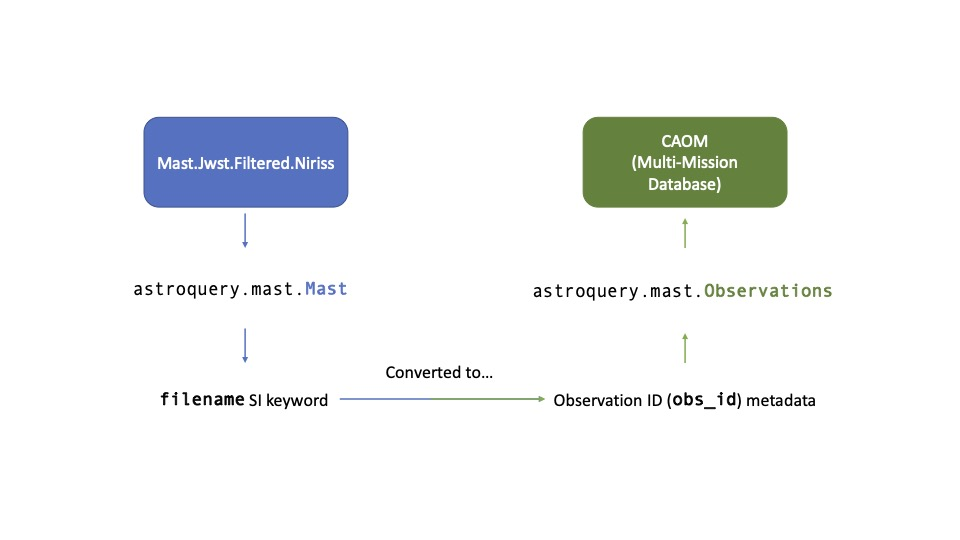

<a id="Construct"></a>
## Construct the Observation Search
The `obs_id` can be derived from the filenames by removing all characters after and including the final underscore character. Here we make a list of unique Observation IDs for the subsequent query. Note that we limit the list to *unique* IDs, as many filenames have common roots.

In [ ]:
# Unique file names:
fn = list(set(t['filename']))

# Set of derived Observation IDs:
ids = list(set(['_'.join(x.split('_')[:-1]) for x in fn]))

Print the list of unique ids if you like.

In [ ]:
ids

<a id="Obs Query"></a>
## Execute the Query for Observations

Now search for Observations that match the list of Observation IDs constructed above. This search uses the [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) `Observations` class, where the available search criteria are [described here](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). 

Note that the Observation ID (`obs_id`) criteria queried for here is not to be confused with the `obsid` that was shown in `Crowded_Fields`: The difference between the two criteria are explained in the CAOM Field Descriptions page linked just above.

In [ ]:
# Getting the observations using the `obs_id`s extracted above
matched_obs = Observations.query_criteria(instrument_name='Niriss', 
                                          obs_id=ids
                                         )

# Let's display the notebook 
display_cols = [x for x in matched_obs.columns if x!='s_region']
matched_obs[display_cols].show_in_notebook(display_length=5)

Verify that your query matched at least one observation, or the remaining steps will fail.

In [ ]:
print(f'Found {len(matched_obs)} matching Observations.')

<a id="Data Products"></a>
# III: Download the Data Products

Next we'll download the data products that are connected to each Observation. In order to do this, we'll need to query for our desired data products using the list of Observations we obtained above.

<a id="Query DP"></a>
## Query for Data Products

Here we take care to fetch the products from Observations a few at a time (in batches) to avoid server timeouts. This can happen if there are a large number of files in one or more of the matched Observations. A larger batch size will execute faster, but increases the risk of a server timeout. A batch size of five offers is significantly faster than "one at a time", while keeping the risk of timeout low.

The following bit of python magic splits one long list into a list of smaller lists, each of which has a size no larger than `batch_size`. 

In [ ]:
batch_size = 5
batches = [matched_obs[i:i+batch_size] for i in range(0, len(matched_obs), batch_size)]

Now fetch the constituent products in a list of tables.

In [ ]:
t = [Observations.get_product_list(obs) for obs in batches]

We need to stack the individual tables and extract a unique set of file names. Observations often have many files in common (e.g., guide-star files) and this will avoid any duplicates.

In [ ]:
products = unique(vstack(t), keys='productFilename')
print(f'  Number of unique products: {len(products)}')

Display the resulting list of files if you like. 

In [ ]:
products.show_in_notebook(display_length=5)

## Filter the Data Products
<a id="Product Filters"></a>

If there are a subset of products of interest (or, a set of products you would like to exclude) there are a number of ways to do that. The cell below applies a filter to select only calibration level 2 and 3 spectral products classified as `SCIENCE` plus the `INFO` files that define product associations; it also excludes guide-star products. See the full set of [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html) for the all queryable fields.

In [ ]:
# Retrieve level 2 and 3 SCIENCE and INFO products of type spectrum.
filtered_products = Observations.filter_products(products,
                                                 productType=['SCIENCE', 'INFO'],
                                                 dataproduct_type='spectrum',
                                                 calib_level=[2, 3]
                                                )

Display selected columns of the filtered products, if you like.

In [ ]:
filtered_products['description','dataURI', 'calib_level', 'size'].show_in_notebook(display_length=10)

<a id="Download Products"></a>
## Download the Data Products

We'll go over your options for data downloads in the sections below. Note that for public data, you will not need to login.

<a id="Login"></a>
### Optional: MAST Login

If you intend to retrieve data that are protected by an Exclusive Access Period (EAP), you will need to be both *authorized* and *authenticated*. You can authenticate by presenting a valid [Auth.MAST](https://auth.mast.stsci.edu/info) token with the login function. (See [MAST User Accounts](https://outerspace.stsci.edu/display/MASTDOCS/MAST+User+Accounts) for more information about whether you need to login.) 

**This step is unnecessary if you are only retrieving public data.**

<div class="alert alert-block alert-warning">

<span style="color:black">
    If you have arrived at this point, wish to retrieve EAP products, and have <b>not</b> establihed a token, you need to do the following:
    <ul>
        <li> Create a token here: <a href="https://auth.mast.stsci.edu/info">Auth.MAST</a>
        <li> Cut/paste the token string in response to the prompt that will appear when downloading the script. </li>
    </ul>
    Defining the token string as an environment variable <b>will not work</b> for an already-running notebook.
</span>
</div>

In [ ]:
# Observations.login()

<a id="Retrieve Files"></a>
### Retrieve FIles

Now let's fetch the products. The example below shows how to retrieve a bash script (rather than direct file download) to retreive our entire list at once. Scripts are a much better choice if the number or size of files in the download manifest is large (more than 100 files or 10GB).

In [ ]:
# Downloading via a bash script.

manifest = Observations.download_products(filtered_products,
                                          curl_flag=True
                                         )

In the interest of time (and not crashing our servers), we will download one small product from our list above. Let's download a reasonably sized 10MB file. The file we choose is raw spectral data, so additional extractiong would be needed for scientific analysis.

In [ ]:
manifest = Observations.download_products(filtered_products[9])

Let's actually visualize the raw data from which you can extract the spectrum:

In [ ]:
sci = fits.getdata(manifest['Local Path'][0], 1)

plt.figure(figsize=(15,150))
plt.imshow(sci);

We are, in effect, seeing the [raw spectrum on the detector](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-single-object-slitless-spectroscopy#NIRISSSingleObjectSlitlessSpectroscopy-SOSSsubarrays); if you look closely at the section of the brightest line in the upper right corner of the figure, you can see absorbtion lines.

<a id="Resources"></a>
# Additional Resources

The links below take you to documentation that you might find useful when constructing queries.

* [astropy](https://docs.astropy.org/en/stable/index.html) documentation
* [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) documentation for querying MAST
* [Field Descriptions for JWST Instrument Keywords](https://mast.stsci.edu/api/v0/_jwst_inst_keywd.html)
* [Queryable fields](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) in the MAST/CAOM database

## About this notebook

This notebook was developed by Archive Sciences Branch staff: chiefly Dick Shaw, with additional editing from Jenny Medina and Thomas Dutkiewicz. For support, please contact the Archive HelpDesk at archive@stsci.edu, or through the [JWST HelpDesk Portal](https://jwsthelp.stsci.edu). 
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>